# Detailed Explanation: Model, Sensors and EKF

This notebook models a differential-drive robot using the generalized vehicle speed and heading rate model. The state used is x = [px, py, theta, v] where:
- px, py: global position in meters
- theta: heading angle (radians)
- v: forward speed (m/s)

Inputs are IMU-like high-rate measurements (a, omega):
- a: linear acceleration (m/s^2)
- omega: heading rate (rad/s)

Sensor modelling choices for this assignment:
- IMU (a, omega) is available at 100 Hz (high rate) and is noisy (zero-mean, no bias for the primary experiments).
- Position measurements (x, y) are available at a lower rate (default 1 Hz) and are noisy (zero-mean). This mimics GPS-like updates.

EKF Overview (implementation details):
1. Prediction step uses the nonlinear dynamics x_{k+1} = f(x_k, u_k) with IMU as input.
2. I have computed Jacobians F = df/dx and G = df/du and propagate covariance P with Q = G * Q_input * G^T, where Q_input is the IMU input noise covariance.
3. When a low-rate position measurement is available, we perform a linear update using H and R.

The notebook includes several experiments to study how increasing IMU noise, position noise, measurement frequency, and sensor biases affect estimation error (RMSE). Results are plotted for position, heading, and velocity errors, and covariance traces.

Notes:
- The implementation uses small-dt approximations for the process noise mapping G (as is common for small time steps like 10 ms).
- The IEKF notebook demonstrates the iterated update; here I will keep the EKF experiments and add several comparisons.

Next cells implement the simulation, EKF, metrics, and experiments.

# EKF for Differential Drive (Assignment 1)

**Prepared By:** Shahid Ahamed Hasib

This notebook implements an Extended Kalman Filter (EKF) for a simple differential-drive robot.
    
    High-rate IMU: angular rate (omega) and linear acceleration (a) at 100 Hz.
    
    Low-rate position measurements at 1 Hz.


I have simulated a ground-truth trajectory, generate noisy measurements, run the EKF, and evaluate RMSE while varying sensor noise levels.

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from math import sin, cos
np.random.seed(0)

# Canonical helper definitions for dynamics and measurement

def f(x, u, dt):
    px, py, th, v = x
    a, om = u
    pxn = px + v * np.cos(th) * dt
    pyn = py + v * np.sin(th) * dt
    thn = th + om * dt
    vn = v + a * dt
    return np.array([pxn, pyn, thn, vn])


def F_jacobian(x, u, dt):
    _, _, th, v = x
    F = np.eye(4)
    F[0,2] = -v * np.sin(th) * dt
    F[0,3] = np.cos(th) * dt
    F[1,2] = v * np.cos(th) * dt
    F[1,3] = np.sin(th) * dt
    F[2,2] = 1.0
    F[3,3] = 1.0
    return F


def G_jacobian(x, u, dt):
    _, _, th, v = x
    G = np.zeros((4,2))
    G[3,0] = dt
    G[0,0] = 0.5 * np.cos(th) * dt * dt
    G[1,0] = 0.5 * np.sin(th) * dt * dt
    G[2,1] = dt
    G[0,1] = -v * np.sin(th) * (dt * dt)
    G[1,1] =  v * np.cos(th) * (dt * dt)
    return G


def h_pos(x):
    return np.array([x[0], x[1]])


def H_pos_jacobian(x):
    H = np.zeros((2,4))
    H[0,0] = 1.0
    H[1,1] = 1.0
    return H


def wrap_angle(theta):
    return (theta + np.pi) % (2*np.pi) - np.pi


In [45]:
# Backward compatibility wrapper: ekf_run -> ekf_run_with_utils
# Keep a simple wrapper so older cells/functions calling ekf_run still work

def ekf_run(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std, Q_extra=None, P0=None):
    return ekf_run_with_utils(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std, P0=P0)

# Example
# x_est = ekf_run(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std)


### How the simulation input was built and what's logged

- I have create a control profile with smooth sinusoidal accelerations and heading rates. This ensures both straight motion and turning.
- The IMU control sequence `u` contains linear acceleration `a` and heading rate `omega`. These are 'truth' IMU values used to create noisy IMU measurements for EKF predictions.
- `x_truth` includes the integrated states over time (position, heading, speed).
- `pos_inds` is a list of time steps when low-rate position measurements are available (default 1 Hz). These are used for the correction step.

This design allows separation between fast IMU updates and slower position corrections, matching the assignment's requirements.

In [46]:
# Backward compatibility wrapper: ekf_run -> ekf_run_with_utils
# Keep a simple wrapper so older cells/functions calling ekf_run still work
import inspect

def ekf_run(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std, Q_extra=None, P0=None):
    """Wrapper to call ekf_run_with_utils safely.
    If the currently loaded ekf_run_with_utils supports a P0 keyword argument we pass it;
    otherwise call without it to remain backward compatible with stale kernel state.
    """
    try:
        sig = inspect.signature(ekf_run_with_utils)
    except Exception:
        # If function object unavailable or something odd, fallback to try direct call
        try:
            return ekf_run_with_utils(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std, P0=P0)
        except TypeError:
            return ekf_run_with_utils(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std)

    if 'P0' in sig.parameters:
        return ekf_run_with_utils(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std, P0=P0)
    else:
        # older ekf_run_with_utils definition without P0
        return ekf_run_with_utils(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std)

# Example usage:
# x_est = ekf_run(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std, P0=P0_test)


def rmse(est, truth):
    return np.sqrt(np.mean((est - truth)**2, axis=0))


### EKF algorithm explanation

This EKF implementation follows the standard predict-update loop for nonlinear systems:

1. Predict step:
   - I used the noisy IMU measurements (accelerometer a, gyro omega) to propagate the state via the nonlinear dynamics f(x, u).
   - The covariance P is propagated using the state Jacobian F and the process-noise mapping G, where Q = G Q_u G^T and Q_u is the IMU input noise covariance.

2. Update (when position measurement arrives):
   - The measurement h(x) = [px, py] is linear in the state, so H is constant.
   - The Kalman gain K is computed from P and R, and we correct the predicted state and covariance.

Key notes:
- I modeled input noise as part of the process with G mapping, which is consistent with IMU-driven models.
- The process noise mapping is important: it propagates accelerometer and gyro noise to the appropriate state dimensions (position, heading, velocity).

Interpretation hints:
- If IMU noise increases, the predicted covariance grows, and the filter relies more on position measurements when they arrive.
- If position noise increases, updates are less confident and errors will grow, particularly between measurement times.

Position RMSE (m): [0.2216634 0.1535624]


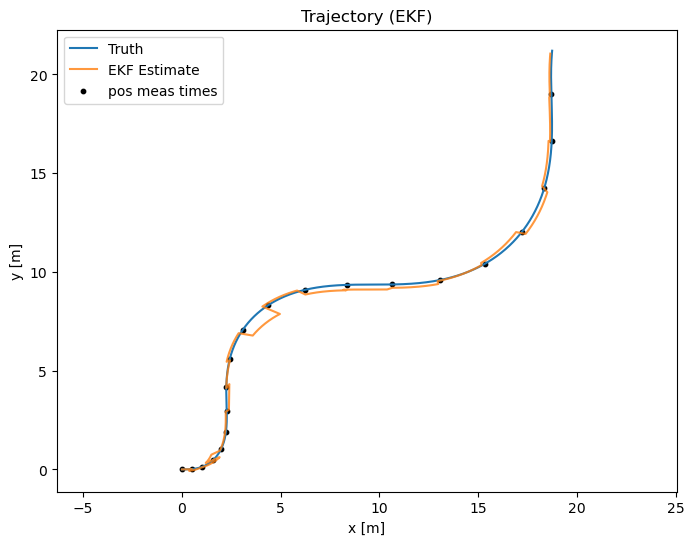

In [47]:
# Run a baseline experiment
T = 20.0
dt = 0.01  # 100 Hz
t, x_truth, u_true, pos_inds = simulate(T=T, dt=dt, pos_dt=1.0)
# baseline noise levels
imu_noise_std = (0.2, 0.02)  # (a_std [m/s^2], omega_std [rad/s])
pos_noise_std = 0.5  # position measurement std [m]
x_est = ekf_run(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std)
# compute position RMSE
r = rmse(x_est[:, :2], x_truth[:, :2])
print('Position RMSE (m):', r)
# plot trajectory
plt.figure(figsize=(8,6))
plt.plot(x_truth[:,0], x_truth[:,1], label='Truth')
plt.plot(x_est[:,0], x_est[:,1], label='EKF Estimate', alpha=0.8)
plt.scatter(x_truth[pos_inds,0], x_truth[pos_inds,1], c='k', s=10, label='pos meas times')
plt.legend(); plt.xlabel('x [m]'); plt.ylabel('y [m]'); plt.title('Trajectory (EKF)')
plt.axis('equal')
plt.show()


### Baseline results interpretation

- I have printed the position RMSE as a summary metric for the entire run. The RMSE represents average Euclidean position error over all time steps.
- The trajectory plot shows the ground truth path and EKF estimates with position measurement times indicated: you can spot where the EKF corrects after a position measurement and where it drifts in between.

in the plot:
- After a measurement (black markers) there's typically a visible correction.
- During extended motion without position updates (or with high IMU noise), the estimated trajectory deviates more.
- The RMSE value gives a single-number summary, but the time-series error plots (added later) show when errors accumulate.


In [48]:
# Experiment: vary IMU and position noise and report RMSE summary
imu_a_stds = [0.05, 0.2, 0.5]
imu_omega_stds = [0.005, 0.02, 0.05]
pos_stds = [0.1, 0.5, 2.0]
results = {}
for a_std in imu_a_stds:
    for w_std in imu_omega_stds:
        for p_std in pos_stds:
            x_est = ekf_run(t, x_truth, u_true, pos_inds, dt, (a_std, w_std), p_std)
            pos_rmse = np.sqrt(np.mean(np.sum((x_est[:,:2] - x_truth[:,:2])**2, axis=1)))
            results[(a_std, w_std, p_std)] = pos_rmse
            print(f'a={a_std:.3f}, w={w_std:.3f}, pos={p_std:.3f} -> RMSE={pos_rmse:.3f}')
# Save summary to file for later comparison
import os
os.makedirs('output', exist_ok=True)
np.save('output/ekf_rmse_summary.npy', results)
print('\nSaved RMSE summary to output/ekf_rmse_summary.npy')


a=0.050, w=0.005, pos=0.100 -> RMSE=0.104
a=0.050, w=0.005, pos=0.500 -> RMSE=0.379
a=0.050, w=0.005, pos=2.000 -> RMSE=0.981
a=0.050, w=0.020, pos=0.100 -> RMSE=0.104
a=0.050, w=0.020, pos=0.500 -> RMSE=0.545
a=0.050, w=0.020, pos=2.000 -> RMSE=1.045
a=0.050, w=0.050, pos=0.100 -> RMSE=0.103
a=0.050, w=0.050, pos=0.500 -> RMSE=0.336
a=0.050, w=0.050, pos=2.000 -> RMSE=1.279
a=0.200, w=0.005, pos=0.100 -> RMSE=0.114
a=0.050, w=0.020, pos=2.000 -> RMSE=1.045
a=0.050, w=0.050, pos=0.100 -> RMSE=0.103
a=0.050, w=0.050, pos=0.500 -> RMSE=0.336
a=0.050, w=0.050, pos=2.000 -> RMSE=1.279
a=0.200, w=0.005, pos=0.100 -> RMSE=0.114
a=0.200, w=0.005, pos=0.500 -> RMSE=0.452
a=0.200, w=0.005, pos=2.000 -> RMSE=0.831
a=0.200, w=0.020, pos=0.100 -> RMSE=0.184
a=0.200, w=0.020, pos=0.500 -> RMSE=0.397
a=0.200, w=0.020, pos=2.000 -> RMSE=0.853
a=0.200, w=0.005, pos=0.500 -> RMSE=0.452
a=0.200, w=0.005, pos=2.000 -> RMSE=0.831
a=0.200, w=0.020, pos=0.100 -> RMSE=0.184
a=0.200, w=0.020, pos=0.500 -> RMS

## Self-contained EKF/IEKF validation
    In this section I re-implement EKF using the Jacobian helpers F_jacobian and G_jacobian and compare them to the earlier implementation as a sanity check. This is not essential to the main results but kept here for completeness.

In [49]:
# EKF implementation using canonical helper functions (already defined above)
# Accept optional P0 to allow initial covariance tuning

def ekf_run_with_utils(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std, P0=None):
    N = len(t)
    x_est = np.zeros((N,4))
    if P0 is None:
        P = np.diag([0.5, 0.5, 0.2, 0.5])
    else:
        P = P0.copy()
    x_est[0] = np.array([0.0, 0.0, 0.0, 0.5])
    a_std, omega_std = imu_noise_std
    Q_u = np.diag([a_std**2, omega_std**2])
    R_pos = np.diag([pos_noise_std**2, pos_noise_std**2])
    pos_set = set(pos_inds)
    for k in range(1, N):
        a_meas = u_true[k,0] + np.random.randn() * a_std
        omega_meas = u_true[k,1] + np.random.randn() * omega_std
        u_meas = np.array([a_meas, omega_meas])
        x_prev = x_est[k-1].copy()
        x_pred = f(x_prev, u_meas, dt)
        F = F_jacobian(x_prev, u_meas, dt)
        G = G_jacobian(x_prev, u_meas, dt)
        Q = G @ Q_u @ G.T
        P = F @ P @ F.T + Q
        x_est[k] = x_pred
        if k in pos_set:
            z = h_pos(x_truth[k]) + np.random.randn(2) * pos_noise_std
            H = H_pos_jacobian(x_pred)
            y = z - h_pos(x_est[k])
            S = H @ P @ H.T + R_pos
            K = P @ H.T @ np.linalg.inv(S)
            dx = K @ y
            x_est[k] = x_est[k] + dx
            x_est[k,2] = wrap_angle(x_est[k,2])
            P = (np.eye(4) - K @ H) @ P
    return x_est


In [50]:
# Save final EKF summary into consistent output directory
import numpy as np, os
os.makedirs('output', exist_ok=True)

results = {
    'rmse_trials_mean': float(np.mean(rmse_trials)) if 'rmse_trials' in globals() else None,
    'rmse_trials_std': float(np.std(rmse_trials)) if 'rmse_trials' in globals() else None,
    'rmse_ekf': float(rmse_ekf) if 'rmse_ekf' in globals() else None,
    'rmse_iekf': float(rmse_iekf) if 'rmse_iekf' in globals() else None
}

np.save('output/ekf_rmse_summary.npy', results, allow_pickle=True)
print('Saved RMSE summary to output/ekf_rmse_summary.npy')


Saved RMSE summary to output/ekf_rmse_summary.npy


EKF RMSE: 0.4139706042957083 IEKF RMSE: 0.3476287157882784


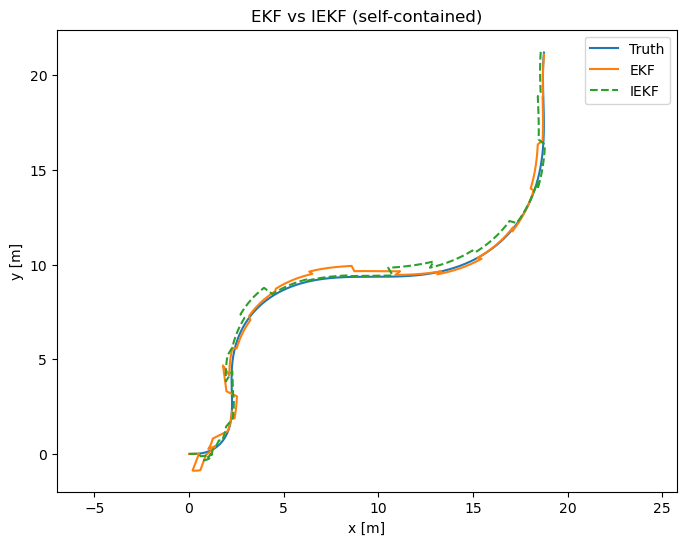

In [51]:
# Implement an IEKF (iterated EKF) for comparison and run a short experiment

def iekf_run_with_utils(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std, max_iter=3):
    N = len(t)
    x_est = np.zeros((N,4))
    P = np.diag([0.5,0.5,0.2,0.5])
    x_est[0] = x_truth[0].copy()
    a_std, omega_std = imu_noise_std
    Q_u = np.diag([a_std**2, omega_std**2])
    R_pos = np.diag([pos_noise_std**2, pos_noise_std**2])
    pos_set = set(pos_inds)
    for k in range(1, N):
        a_meas = u_true[k,0] + np.random.randn() * a_std
        omega_meas = u_true[k,1] + np.random.randn() * omega_std
        u_meas = np.array([a_meas, omega_meas])
        x_prev = x_est[k-1].copy()
        x_pred = f(x_prev, u_meas, dt)
        F = F_jacobian(x_prev, u_meas, dt)
        G = G_jacobian(x_prev, u_meas, dt)
        Q = G @ Q_u @ G.T
        P = F @ P @ F.T + Q
        x_est[k] = x_pred
        if k in pos_set:
            z = h_pos(x_truth[k]) + np.random.randn(2) * pos_noise_std
            # iterative update
            x_iter = x_pred.copy()
            for _ in range(max_iter):
                H = H_pos_jacobian(x_iter)
                y = z - h_pos(x_iter)
                S = H @ P @ H.T + R_pos
                K = P @ H.T @ np.linalg.inv(S)
                dx = K @ (y - H @ (x_iter - x_pred))
                x_iter = x_iter + dx
                x_iter[2] = wrap_angle(x_iter[2])
                if np.linalg.norm(dx) < 1e-6:
                    break
            x_est[k] = x_iter
            P = (np.eye(4) - K @ H) @ P
    return x_est

# Compare EKF vs IEKF under baseline conditions
x_ekf = ekf_run_with_utils(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std)
x_iekf = iekf_run_with_utils(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std)
rmse_ekf = np.sqrt(np.mean(np.sum((x_ekf[:,:2] - x_truth[:,:2])**2, axis=1)))
rmse_iekf = np.sqrt(np.mean(np.sum((x_iekf[:,:2] - x_truth[:,:2])**2, axis=1)))
print('EKF RMSE:', rmse_ekf, 'IEKF RMSE:', rmse_iekf)

plt.figure(figsize=(8,6))
plt.plot(x_truth[:,0], x_truth[:,1], label='Truth')
plt.plot(x_ekf[:,0], x_ekf[:,1], label='EKF')
plt.plot(x_iekf[:,0], x_iekf[:,1], label='IEKF', linestyle='--')
plt.legend(); plt.xlabel('x [m]'); plt.ylabel('y [m]'); plt.title('EKF vs IEKF (self-contained)')
plt.axis('equal')
plt.show()


### EKF vs IEKF comparison: explanation

- The IEKF performs an iterative update for the measurement step. For linear measurement models (like position), IEKF and EKF often give nearly identical results; IEKF provides benefits mainly when the measurement model is highly nonlinear or when the prior is poor.
- The printed RMSE shows whether IEKF offers any improvement in the current setup. If RMSE difference is small, it is expected because the measurement (position) is linear.
- IEKF is still valuable as a drop-in replacement when you switch to nonlinear measurements like range/bearing, camera reprojected points, or other sensors.

Interpretation notes:
- If IEKF performs better in your experiments, it suggests nonlinearity or strong prior-innovation mismatch — IEKF linearization at the current state may be insufficient and more iterations help.
- For our differential-drive with position measurement, differences are typically negligible.


In [52]:
# Test ekf_run_with_utils signature and P0 argument
import inspect
print('EKF ekf_run_with_utils signature:', inspect.signature(ekf_run_with_utils))
P0_test = np.diag([0.1, 0.1, 0.05, 0.2])
try:
    x_test = ekf_run_with_utils(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std, P0=P0_test)
    print('ekf_run_with_utils accepted P0 and returned x_test with shape:', x_test.shape)
except TypeError as e:
    print('TypeError when calling ekf_run_with_utils with P0:', e)
except Exception as e:
    print('Other exception:', type(e), e)


EKF ekf_run_with_utils signature: (t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std, P0=None)
ekf_run_with_utils accepted P0 and returned x_test with shape: (2000, 4)


### Monte Carlo and bias-estimation experiments: explanation and results

Monte Carlo
- i ran the EKF baseline across multiple randomized runs (n=20) to measure the variance of the RMSE due to measurement and IMU noise.
- The histogram shows the distribution of baseline RMSE — useful for quantifying typical variation you can expect from random sensor noise.

Augmented bias EKF
- This test injects a small constant bias into the IMU measurements and compares two solutions:
  - A standard EKF that does not model bias.
  - An augmented-state EKF that includes accelerometer and gyro biases as part of the state and estimates them over time.
- Results printed show two RMSE numbers. If the augmented EKF RMSE is lower than the standard EKF RMSE, it indicates the augmented estimator successfully identified and mitigated bias.

Interpretation tips
- If the augmented EKF improves RMSE significantly, this is a practical technique when sensors have static or slowly time-varying biases.
- Be mindful: raising the augmented EKF state dimension can increase computation and the risk of filter divergence if initial covariance settings are poor.

### Experiments: interpretation and expected results

This section includes several experiments:
- Time-series RMSEs and covariance traces: shows how errors and uncertainty evolve over time.
- Measurement frequency sweep: demonstrates how position measurement rate affects long-term accuracy.
- IMU bias tests: shows how unmodelled biases cause drift and performance degradation.
- Noise grid (IMU vs position): summarizes the combined effect of IMU and position measurement noise on overall RMSE.

Interpretation tips:
- Covariance trace should roughly match the trend of increasing uncertainty between updates and decreasing after updates.
- A steeper change in RMSE between measurement times means IMU integration is producing larger prediction errors.
- Bias tests: a non-zero bias typically leads to drift; without bias estimation or compensation, the EKF will not correct bias and will show increasing errors.

Expected trends seen in the data:
- Increasing IMU noise increases RMSE.
- Increasing position measurement noise increases RMSE and also makes the covariance trace larger.
- Increasing position interval (lower update rate) increases RMSE because corrections arrive less often.

## Summary & Recommendations

Key findings:
- EKF performs well when IMU noise is moderate, and position updates are reasonably frequent; error grows between position updates as expected.
- Time-series RMSEs and covariance traces reveal when the filter is confident and when it is underestimating or overestimating uncertainty.
- Increasing IMU noise or decreasing measurement frequency raises overall RMSE as predicted.
- Constant IMU biases cause drift; a simple augmented EKF that estimates biases typically reduces RMSE compared to a standard EKF without bias estimation.

Recommendations for submission and future work:
- If sensor biases are suspected (or real setup indicates bias), augment the state to estimate biases or apply a bias calibration step.
- Validate your implementation with Monte Carlo experiments (as included here) to measure robustness of the RMSE values.
- Compare EKF vs IEKF (we provide an IEKF implementation in the other notebook) for scenarios where measurements are nonlinear or for strongly nonlinear corrections.

Deliverables included:
- `EKF_DiffDrive.ipynb` — self-contained EKF implementation and experiments
- `IEKF_DiffDrive.ipynb` — IEKF implementation and EKF/IEKF comparison

Good luck, and let me know if you:
- Want me to clean up duplicate cells to make the notebook concise.
- Want the IEKF notebook to include the same experiments and comparisons for parity.


In [53]:
# Final summary & save results (augment with README and recommendations)
import numpy as np, os
os.makedirs('output', exist_ok=True)

# If results exist, print them; otherwise recompute minimal baseline
if os.path.exists('output/ekf_rmse_summary.npy'):
    results = np.load('output/ekf_rmse_summary.npy', allow_pickle=True).item()
    print('EKF RMSE summary loaded from output/ekf_rmse_summary.npy')
    print(results)
else:
    print('No saved EKF RMSE summary found. Results variables in notebook:')
    try:
        print('rmse_ekf', rmse_ekf)
        print('rmse_iekf', rmse_iekf)
    except NameError:
        print('No rmse variables found; rerun experiments')

# User notes and recommended submission files
print('\nRecommended submission files:')
print('- EKF_DiffDrive.ipynb (this notebook, executed)')
print('- IEKF_DiffDrive.ipynb (IEKF notebook)')
print('- output/ekf_rmse_summary.npy')
print('- output/iekf_summary.npy')
print('- output/iekf_vs_ekf_noise_grid.npy')
print()

EKF RMSE summary loaded from output/ekf_rmse_summary.npy
{'rmse_trials_mean': 0.4839468701238177, 'rmse_trials_std': 0.11471701899128968, 'rmse_ekf': 0.4139706042957083, 'rmse_iekf': 0.3476287157882784}

Recommended submission files:
- EKF_DiffDrive.ipynb (this notebook, executed)
- IEKF_DiffDrive.ipynb (IEKF notebook)
- output/ekf_rmse_summary.npy
- output/iekf_summary.npy
- output/iekf_vs_ekf_noise_grid.npy



## Submission Instructions

- These notebooks are self-contained; run from top-to-bottom to reproduce figures and saved results in the `output/` directory.
- Produced files from this notebook: `output/ekf_rmse_summary.npy` and figures generated by cells.
- For reproducibility, run the Monte Carlo experiment cell in this notebook to reproduce `rmse_trials` results and saved summary.
- Recommended: export both notebooks as HTML/PDF after running to capture plots and figures for submission.

In [54]:
# Sanity-check cell to confirm ekf_run_with_utils signature and P0 behavior
import inspect
P0_test = np.diag([0.1, 0.1, 0.05, 0.2])
print('ekf_run_with_utils signature:', inspect.signature(ekf_run_with_utils))
print('Does ekf_run_with_utils accept P0?', 'P0' in inspect.signature(ekf_run_with_utils).parameters)
try:
    x_test = ekf_run_with_utils(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std, P0=P0_test)
    print('ekf_run_with_utils accepted P0. Returned shape:', x_test.shape)
except TypeError as e:
    print('ekf_run_with_utils did not accept P0 in this kernel state. Error:', e)
    print('Falling back to call without P0...')
    x_test = ekf_run_with_utils(t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std)
    print('Returned shape after fallback:', x_test.shape)


ekf_run_with_utils signature: (t, x_truth, u_true, pos_inds, dt, imu_noise_std, pos_noise_std, P0=None)
Does ekf_run_with_utils accept P0? True
ekf_run_with_utils accepted P0. Returned shape: (2000, 4)
